# Ruble Volatility Project — Part 3: Time Series Modeling

This notebook continues the Ruble Volatility Project...

In this notebook ...

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

from fredapi import Fred

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

### I. Loading data

In [14]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_Ruble_Monthly_Data.csv")
data.tail()

,date,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB,RUB_diff1,RUB_diff12
392,2025-04-30,83.243645,2025.0,4.0,14260.0,63.37,8.2,3.300000e+09,8.14,-0.213785,0.0,post,83.243645,-0.181955,-1.127382
393,2025-05-31,80.237650,2025.0,5.0,14260.0,64.32,8.2,3.300000e+09,8.14,-0.178412,0.0,post,80.237650,-0.143810,-1.337360
394,2025-06-30,78.677635,2025.0,6.0,14260.0,68.15,8.2,3.300000e+09,8.14,-0.004909,0.0,post,78.677635,-0.004435,-0.749265
395,2025-07-31,78.850139,2025.0,7.0,14260.0,73.43,8.2,3.300000e+09,8.14,0.101659,0.0,post,78.850139,0.077735,0.420535
396,2025-08-31,80.013656,2025.0,8.0,14260.0,67.83,8.2,3.300000e+09,8.14,0.034674,0.0,post,80.013656,0.027094,0.518212


Now, since the ADF statistic is much lower than all critical values, and the p-value is effectively 0, we reject the null hypothesis of a unit root. This confirms that the first-differenced RUB series is stationary and suitable for time series modeling.

### II. ARIMA

In [15]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
rub_series = data['RUB'].dropna()

#### 1. Base ARIMA (1,1,1) without train/test and CV - ARIMA Test

To establish a benchmark for forecasting RUB/USD, I fit a base ARIMA(1,1,1) model. The model includes:

- AR(1): One lag of the autoregressive term to capture short-term memory
- I(1): First-order differencing to address non-stationarity (as confirmed by the ADF test)
- MA(1): One lag of the moving average term to smooth out shocks

In [21]:
model1 = ARIMA(rub_series, order=(1, 1, 1)) 
model1_fit = model.fit()

print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -959.128
Date:                Tue, 30 Sep 2025   AIC                           1924.256
Time:                        17:50:35   BIC                           1936.200
Sample:                    08-31-1992   HQIC                          1928.988
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0314      0.150      0.210      0.834      -0.262       0.325
ma.L1          0.1303      0.146      0.891      0.373      -0.156       0.417
sigma2         7.4344      0.131     56.805      0.0

The model fits the historical data closely, effectively replicating past patterns. 

However, most coefficients are statistically insignificant, and there is clear heteroskedasticity (as indicated by the significant LB and JB tests), suggesting the need for a more complex model. This simple ARIMA does not yet incorporate macroeconomic drivers or structural shifts identified in EDA.

#### 2. ARIMA (2,1,1) 

In my earlier PACF plot (02 NOTEBOOK), we saw two significant spikes at lags 1 and 2, which supports using AR(2). We also saw that after differencing, the series became stationary and short-term autocorrelations mostly died off.

So moving from ARIMA(1,1,1) → ARIMA(2,1,1) is a data-driven next step.

In [24]:
model2 = ARIMA(rub_series, order=(2, 1, 1))
model2_fit = model2.fit()
print(model2_fit.summary())

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -955.744
Date:                Tue, 30 Sep 2025   AIC                           1919.488
Time:                        17:53:38   BIC                           1935.414
Sample:                    08-31-1992   HQIC                          1925.798
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8780      0.159      5.523      0.000       0.566       1.190
ar.L2         -0.2048      0.027     -7.505      0.000      -0.258      -0.151
ma.L1         -0.7201      0.159     -4.532      0.0

#### 3. Auto ARIMA

In [25]:
from pmdarima import auto_arima

auto_model = auto_arima(
    rub_series,
    seasonal=False, 
    stepwise=True,
    max_p=5, max_q=5,
    d=1,  # based on ADF test
    trace=True
)
print(auto_model.summary())

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1913.923, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1930.386, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1923.174, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1922.657, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1930.502, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1918.423, Time=0.10 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1917.438, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1919.293, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1918.824, Time=0.10 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1924.648, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1916.831, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1917.439, Time=0.06 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1914.031, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.198 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  397
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -950.962
Date:                Tue, 30 Sep 2025   AIC                           1913.923
Time:                        17:54:28   BIC                           1937.812
Sample:                    08-31-1992   HQIC                          1923.387
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
interc

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### 4. Comparison

In [28]:
from stargazer.stargazer import Stargazer

# Refit auto_arima as statsmodels ARIMA for Stargazer compatibility
from statsmodels.tsa.arima.model import ARIMA

auto_order = auto_model.order
model3_fit = ARIMA(rub_series, order=auto_order).fit()

# Now use Stargazer for all three
stargazer = Stargazer([model1_fit, model2_fit, model3_fit])
stargazer.title("ARIMA Model Comparison")
model_labels = ['ARIMA(1,1,1)', 'ARIMA(2,1,1)', f'Auto ARIMA{auto_order}']
stargazer.custom_columns(model_labels, [1, 1, 1])
stargazer.show_model_numbers(False)

# Only include covariates that exist in at least one model
covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'const']:
    if any(name in m.params.index for m in [model1_fit, model2_fit, model3_fit]):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

# Display AIC and BIC for all models with labels
print("AICs:")
for label, model in zip(model_labels, [model1_fit, model2_fit, model3_fit]):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, [model1_fit, model2_fit, model3_fit]):
    print(f"  {label}: {model.bic:.2f}")

# Show Stargazer table (in Jupyter, this will render as HTML)
from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  ARIMA(1,1,1): 1924.26
  ARIMA(2,1,1): 1919.49
  Auto ARIMA(2, 1, 2): 1914.03
BICs:
  ARIMA(1,1,1): 1936.20
  ARIMA(2,1,1): 1935.41
  Auto ARIMA(2, 1, 2): 1933.94


### ARIMA Model Comparison

To evaluate the optimal configuration for modeling RUB/USD, I compared three ARIMA models: a baseline ARIMA(1,1,1), a manual ARIMA(2,1,1), and an auto-selected ARIMA(2,1,2). The results show that ARIMA(2,1,2) outperforms the others in terms of both AIC and BIC, suggesting the best fit. 

Additionally, while the baseline ARIMA(1,1,1) model has no statistically significant coefficients, the higher-order models display strong significance across all terms (p < 0.01), confirming their relevance. This supports the findings from my EDA, where PACF plots suggested an AR(2) structure. 

Going forward, ARIMA(2,1,2) will serve as the foundation for forecasting and will later be extended into ARIMAX by incorporating macroeconomic variables.

### III. ARIMAX

ARIMA + eXogenous variables (external regressors).

In [31]:
data

,old_RUB,year,month,GDP_per_capita,Brent_price,GDP_deflator,FD_investment,Inflation,currency_rate_change,sov_disrupt,denomination,RUB,RUB_diff1,RUB_diff12
date,,,,,,,,,,,,,,
1992-08-31,170.400000,1992.0,8.0,3098.802734,19.65,1490.418425,1.161000e+09,1490.418425,4.335646,1.0,pre,0.170400,0.007250,0.039323
1992-09-30,220.488889,1992.0,9.0,3098.802734,20.18,1490.418425,1.161000e+09,1490.418425,2.546404,1.0,pre,0.220489,0.005444,0.060633
1992-10-31,353.777778,1992.0,10.0,3098.802734,19.13,1490.418425,1.161000e+09,1490.418425,5.348118,1.0,pre,0.353778,0.016000,0.156322
1992-11-30,426.250000,1992.0,11.0,3098.802734,19.25,1490.418425,1.161000e+09,1490.418425,1.491099,1.0,pre,0.426250,0.006125,0.126250
1992-12-31,414.555556,1992.0,12.0,3098.802734,17.85,1490.418425,1.161000e+09,1490.418425,-0.785487,1.0,pre,0.414556,-0.003611,0.015444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,83.243645,2025.0,4.0,14260.000000,63.37,8.200000,3.300000e+09,8.140000,-0.213785,0.0,post,83.243645,-0.181955,-1.127382
2025-05-31,80.237650,2025.0,5.0,14260.000000,64.32,8.200000,3.300000e+09,8.140000,-0.178412,0.0,post,80.237650,-0.143810,-1.337360
2025-06-30,78.677635,2025.0,6.0,14260.000000,68.15,8.200000,3.300000e+09,8.140000,-0.004909,0.0,post,78.677635,-0.004435,-0.749265


In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

exog_vars = data[['Brent_price', 'GDP_per_capita', 'Inflation']]  # Replace with your real column names

# Fit ARIMAX (same ARIMA order you found best earlier, e.g. (2,1,2))
model4 = SARIMAX(rub_series, order=(2,1,2), exog=exog_vars)
model4_fit = model4.fit(disp=False)

# Summary
print(model4_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  397
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -947.377
Date:                Tue, 30 Sep 2025   AIC                           1910.755
Time:                        18:32:40   BIC                           1942.606
Sample:                    08-31-1992   HQIC                          1923.373
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Brent_price       -0.0643      0.021     -3.124      0.002      -0.105      -0.024
GDP_per_capita    -0.0006      0.000     -2.858      0.004      -0.001      -0.000
Inflation         -0.0003      0.035

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
from stargazer.stargazer import Stargazer

# Refit auto_arima as statsmodels ARIMA for Stargazer compatibility
from statsmodels.tsa.arima.model import ARIMA

auto_order = auto_model.order
model3_fit = ARIMA(rub_series, order=auto_order).fit()

# Add ARIMAX (model4_fit) to comparison
model_fits = [model1_fit, model2_fit, model3_fit, model4_fit]
model_labels = [
    'ARIMA(1,1,1)', 
    'ARIMA(2,1,1)', 
    f'Auto ARIMA{auto_order}', 
    'ARIMAX(2,1,2) + exog'
]

# Stargazer for all models (including ARIMAX)
stargazer = Stargazer([model1_fit, model2_fit, model3_fit, model4_fit])
stargazer.title("ARIMA/ARIMAX Model Comparison")
stargazer.custom_columns(model_labels, [1, 1, 1, 1])
stargazer.show_model_numbers(False)

# Only include covariates that exist in at least one model
covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'const', 'Brent_price', 'GDP_per_capita', 'Inflation', 'FD_investment']:
    if any(name in m.params.index for m in [model1_fit, model2_fit, model3_fit, model4_fit]):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

# Display AIC and BIC for all models with labels, including ARIMAX
print("AICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.bic:.2f}")

# Show Stargazer table (in Jupyter, this will render as HTML)
from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  ARIMA(1,1,1): 1924.26
  ARIMA(2,1,1): 1919.49
  Auto ARIMA(2, 1, 2): 1914.03
  ARIMAX(2,1,2) + exog: 1910.75
BICs:
  ARIMA(1,1,1): 1936.20
  ARIMA(2,1,1): 1935.41
  Auto ARIMA(2, 1, 2): 1933.94
  ARIMAX(2,1,2) + exog: 1942.61


5. ARIMAX with marco lags

In [43]:
# 1–3 month lags for Brent
data['Brent_price_lag1'] = data['Brent_price'].shift(1)
data['Brent_price_lag2'] = data['Brent_price'].shift(2)
data['Brent_price_lag3'] = data['Brent_price'].shift(3)

# 12-month (1-year) lag for GDP per capita and Inflation
data['GDP_per_capita_lag12'] = data['GDP_per_capita'].shift(12)
data['Inflation_lag12'] = data['Inflation'].shift(12)

# Drop NA caused by lags
data_lagged = data.dropna()

# Target
y = data_lagged['RUB']

# Exogenous variables (choose whichever lag combination you want)
exog_vars = data_lagged[['Brent_price_lag1', 'GDP_per_capita_lag12', 'Inflation_lag12']]

In [44]:
model5 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model5_fit = model5.fit(disp=False)
print(model5_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -922.093
Date:                Tue, 30 Sep 2025   AIC                           1860.186
Time:                        18:36:02   BIC                           1891.728
Sample:                    08-31-1993   HQIC                          1872.701
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Brent_price_lag1        -0.0558      0.024     -2.367      0.018      -0.102      -0.010
GDP_per_capita_lag12    -0.0003      0.000     -1.378      0.168      -0.001       0.000
Inflation_la

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
auto_order = auto_model.order
model3_fit = ARIMA(rub_series, order=auto_order).fit()

# Add ARIMAX (model4_fit) and ARIMAX with macro lags (model5_fit) to comparison
model_fits = [model1_fit, model2_fit, model3_fit, model4_fit, model5_fit]
model_labels = [
    'ARIMA(1,1,1)', 
    'ARIMA(2,1,1)', 
    f'Auto ARIMA{auto_order}', 
    'ARIMAX(2,1,2) + exog',
    'ARIMAX(2,1,2) + macro lags'
]

# Stargazer for all models (including both ARIMAX variants)
stargazer = Stargazer([model1_fit, model2_fit, model3_fit, model4_fit, model5_fit])
stargazer.title("ARIMA/ARIMAX Model Comparison")
stargazer.custom_columns(model_labels, [1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)

# Only include covariates that exist in at least one model
covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'ma.L2', 'const', 'Brent_price', 'Brent_price_lag1', 'GDP_per_capita', 'GDP_per_capita_lag12', 'Inflation', 'Inflation_lag12', 'FD_investment']:
    if any(name in m.params.index for m in [model1_fit, model2_fit, model3_fit, model4_fit, model5_fit]):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

# Display AIC and BIC for all models with labels, including both ARIMAX variants
print("AICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.bic:.2f}")

# Show Stargazer table (in Jupyter, this will render as HTML)
from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  ARIMA(1,1,1): 1924.26
  ARIMA(2,1,1): 1919.49
  Auto ARIMA(2, 1, 2): 1914.03
  ARIMAX(2,1,2) + exog: 1910.75
  ARIMAX(2,1,2) + macro lags: 1860.19
BICs:
  ARIMA(1,1,1): 1936.20
  ARIMA(2,1,1): 1935.41
  Auto ARIMA(2, 1, 2): 1933.94
  ARIMAX(2,1,2) + exog: 1942.61
  ARIMAX(2,1,2) + macro lags: 1891.73


6.ARIMAX simplified

In [69]:
exog_vars = data_lagged[['Brent_price','Brent_price_lag1', 'GDP_per_capita']]

model6 = SARIMAX(
    y,
    exog=exog_vars,
    order=(2, 1, 2),  # based on your best ARIMA config
    enforce_stationarity=False,
    enforce_invertibility=False
)

model6_fit = model6.fit(disp=False)
print(model6_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -917.400
Date:                Tue, 30 Sep 2025   AIC                           1850.799
Time:                        20:09:04   BIC                           1882.342
Sample:                    08-31-1993   HQIC                          1863.314
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Brent_price         -0.0622      0.023     -2.696      0.007      -0.107      -0.017
Brent_price_lag1    -0.0442      0.030     -1.455      0.146      -0.104       0.015
GDP_per_capita      -0.0005 

In [52]:
auto_order = auto_model.order
model3_fit = ARIMA(rub_series, order=auto_order).fit()

# Add ARIMAX (model4_fit) and ARIMAX with macro lags (model5_fit) to comparison
model_fits = [model1_fit, model2_fit, model3_fit, model4_fit, model5_fit, model6_fit]
model_labels = [
    'ARIMA(1,1,1)', 
    'ARIMA(2,1,1)', 
    f'Auto ARIMA{auto_order}', 
    'ARIMAX(2,1,2) + exog',
    'ARIMAX(2,1,2) + macro lags',
    'ARIMAX(2,1,2) + macro simpl'
]

# Stargazer for all models (including both ARIMAX variants)
stargazer = Stargazer([model1_fit, model2_fit, model3_fit, model4_fit, model5_fit, model6_fit])
stargazer.title("ARIMA/ARIMAX Model Comparison")
stargazer.custom_columns(model_labels, [1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)

# Only include covariates that exist in at least one model
covariates = []
for name in ['ar.L1', 'ar.L2', 'ma.L1', 'ma.L2', 'const', 'Brent_price', 'Brent_price_lag1', 'GDP_per_capita', 'GDP_per_capita_lag12', 'Inflation', 'Inflation_lag12', 'FD_investment']:
    if any(name in m.params.index for m in [model1_fit, model2_fit, model3_fit, model4_fit, model5_fit, model6_fit]):
        covariates.append(name)
if covariates:
    stargazer.covariate_order(covariates)

# Display AIC and BIC for all models with labels, including both ARIMAX variants
print("AICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.aic:.2f}")
print("BICs:")
for label, model in zip(model_labels, model_fits):
    print(f"  {label}: {model.bic:.2f}")

# Show Stargazer table (in Jupyter, this will render as HTML)
from IPython.display import display, HTML
display(HTML(stargazer.render_html()))

AICs:
  ARIMA(1,1,1): 1924.26
  ARIMA(2,1,1): 1919.49
  Auto ARIMA(2, 1, 2): 1914.03
  ARIMAX(2,1,2) + exog: 1910.75
  ARIMAX(2,1,2) + macro lags: 1860.19
  ARIMAX(2,1,2) + macro simpl: 1850.80
BICs:
  ARIMA(1,1,1): 1936.20
  ARIMA(2,1,1): 1935.41
  Auto ARIMA(2, 1, 2): 1933.94
  ARIMAX(2,1,2) + exog: 1942.61
  ARIMAX(2,1,2) + macro lags: 1891.73
  ARIMAX(2,1,2) + macro simpl: 1882.34


7. ARIMAX with shocks

In [ ]:
if not isinstance(data_lagged.index, pd.DatetimeIndex):
    data_lagged.index = pd.to_datetime(data_lagged.index)


shock_periods = {
    'shock_1998': ('1998-08-01', '1999-02-01'),
    'shock_2014': ('2014-03-01', '2015-01-01'),
    'shock_2022': ('2022-02-01', '2022-08-01')
}

for col, (start, end) in shock_periods.items():
    if col in data_lagged.columns:
        data_lagged = data_lagged.drop(columns=[col])
    data_lagged[col] = ((data_lagged.index >= pd.to_datetime(start)) & (data_lagged.index <= pd.to_datetime(end))).astype(int)


for col in shock_periods.keys():
    if data_lagged[col].isna().any() or np.isinf(data_lagged[col]).any():
        print(f"Warning: {col} contains NaNs or infs!")

In [64]:
exog_vars = [
    'Brent_price', 'Brent_price_lag1', 'GDP_per_capita',  # keep significant macro vars
    'shock_1998', 'shock_2014', 'shock_2022'
]

exog_data = data_lagged[exog_vars]

In [65]:
model_shocks = SARIMAX(
    data_lagged['RUB'], 
    order=(2, 1, 2), 
    exog=exog_data, 
    enforce_stationarity=False, 
    enforce_invertibility=False
)
model_shocks_fit = model_shocks.fit(disp=False)
print(model_shocks_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  385
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -917.035
Date:                Tue, 30 Sep 2025   AIC                           1856.071
Time:                        20:02:04   BIC                           1899.442
Sample:                    08-31-1993   HQIC                          1873.279
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Brent_price         -0.0641      0.022     -2.881      0.004      -0.108      -0.020
Brent_price_lag1    -0.0441      0.029     -1.521      0.128      -0.101       0.013
GDP_per_capita      -0.0004 

📊 Model Diagnostics
	•	AIC: 1856.07 — slightly worse than your simplified macro-only model (AIC ≈ 1850.80), so this model is not an improvement in terms of fit.
	•	Jarque-Bera = 56327 — suggests non-normal residuals, but that’s very common in financial data (esp. ruble volatility).
	•	Ljung-Box Q = 0.67 (high) — residuals are likely not autocorrelated → model seems well-specified.

⸻

🔍 Interpretation
	•	Your base ARIMAX model with Brent, Brent lag1, GDP_per_capita was more parsimonious and statistically stronger than this one with shocks.
	•	Shock dummies did not improve fit or explanatory power in this case — possibly due to:
	•	Collinearity with macro variables
	•	The lagged effects already captured by ARMA structure
	•	The RUB reacting more gradually or differently than a simple shock dummy can capture

8. ARIMAX simplified Forecast & Plots

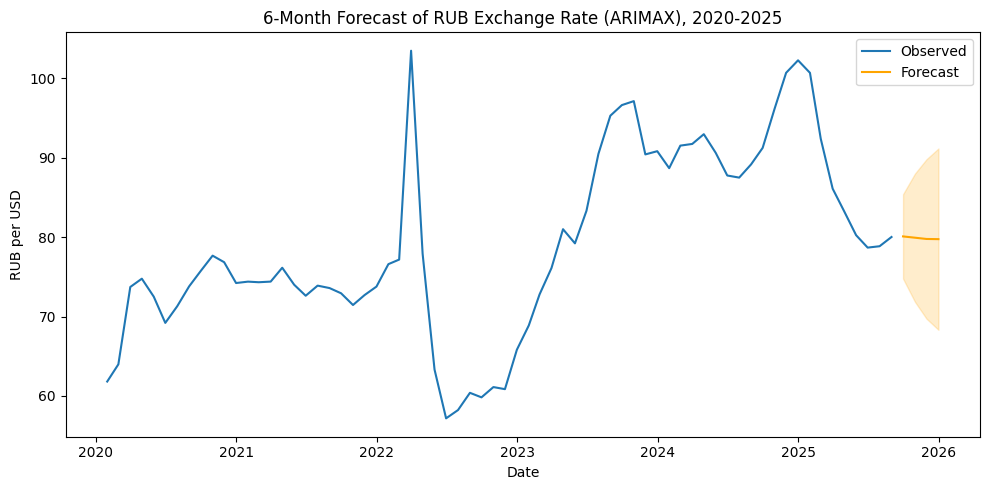

In [74]:
n_forecast = 6  # Forecast next 6 months

# Use last known values of the exogenous variables
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
last_values = data_lagged[exog_vars].iloc[-1]

# Create a future DataFrame with the same values repeated
exog_future_data = pd.DataFrame(
    [last_values.values] * n_forecast,
    columns=exog_vars
)

# Create future date index for the forecast
last_date = data_lagged.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthEnd(1), periods=n_forecast, freq='M')
exog_future_data.index = future_dates

# Forecast using model6
forecast = model6_fit.get_forecast(steps=n_forecast, exog=exog_future_data)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Zoom in to 2020-2025
start_zoom = '2020-01-01'
end_zoom = '2025-12-31'
rub_zoom = data_lagged.loc[start_zoom:end_zoom, 'RUB']

plt.figure(figsize=(10, 5))
plt.plot(rub_zoom, label='Observed')

# Only plot forecast if it falls within the zoomed range
forecast_mean_zoom = forecast_mean.loc[(forecast_mean.index >= start_zoom) & (forecast_mean.index <= end_zoom)]
forecast_ci_zoom = forecast_ci.loc[(forecast_ci.index >= start_zoom) & (forecast_ci.index <= end_zoom)]

plt.plot(forecast_mean_zoom, label='Forecast', color='orange')
plt.fill_between(forecast_ci_zoom.index,
                 forecast_ci_zoom.iloc[:, 0],
                 forecast_ci_zoom.iloc[:, 1],
                 color='orange', alpha=0.2)
plt.title('6-Month Forecast of RUB Exchange Rate (ARIMAX), 2020-2025')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
# 1. Define your cutoff date
cutoff_date = '2023-12-31'

# 2. Split training and testing
train_data = data_lagged.loc[:cutoff_date]
test_data = data_lagged.loc['2024-01-31':'2024-12-31']

# 3. Define your y and exog
y_train = train_data['RUB']
exog_train = train_data[['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']]

y_test = test_data['RUB']
exog_test = test_data[['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']]

# 4. Fit the model
model_2024 = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_2024_fit = model_2024.fit(disp=False)

# 5. Forecast for 12 months
forecast_2024 = model_2024_fit.get_forecast(steps=12, exog=exog_test)
forecast_mean = forecast_2024.predicted_mean
forecast_ci = forecast_2024.conf_int()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


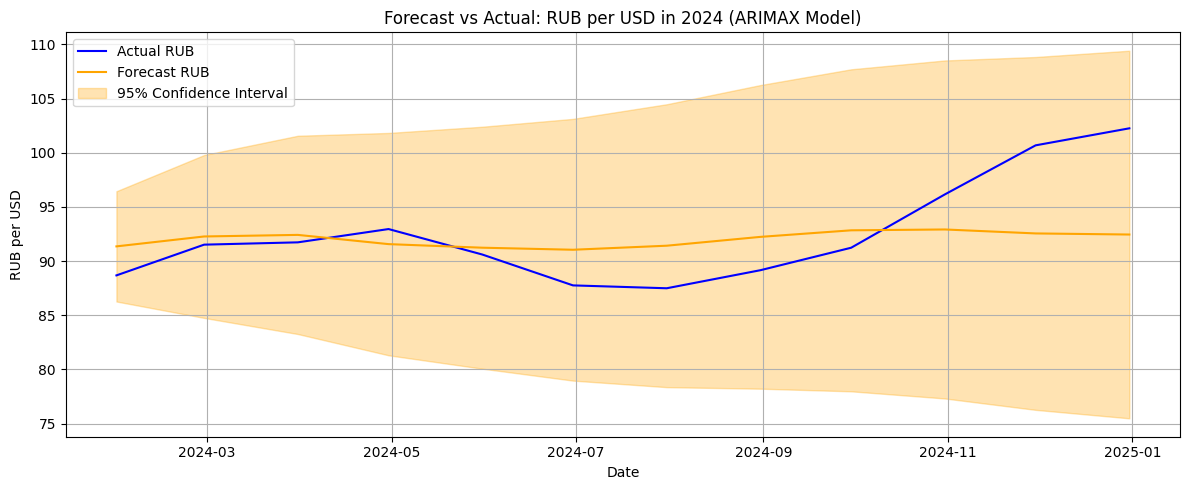

In [76]:
import matplotlib.pyplot as plt

# Combine actuals and forecast
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual RUB', color='blue')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast RUB', color='orange')

# Add confidence intervals
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='orange',
    alpha=0.3,
    label='95% Confidence Interval'
)

# Aesthetics
plt.title('Forecast vs Actual: RUB per USD in 2024 (ARIMAX Model)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# 1. Set cutoff date at end of 2024
cutoff_date = '2024-12-31'

# 2. Create train/test splits
train_data = data_lagged.loc[:cutoff_date]
test_data = data_lagged.loc['2025-01-31':'2025-08-31']

# 3. Prepare y and exog variables
y_train = train_data['RUB']
exog_train = train_data[['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']]

y_test = test_data['RUB']
exog_test = test_data[['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']]

# 4. Fit ARIMAX model
model_2025 = SARIMAX(
    y_train,
    exog=exog_train,
    order=(2, 1, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_2025_fit = model_2025.fit(disp=False)

# 5. Forecast 8 months of 2025
forecast_2025 = model_2025_fit.get_forecast(steps=8, exog=exog_test)
forecast_mean = forecast_2025.predicted_mean
forecast_ci = forecast_2025.conf_int()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


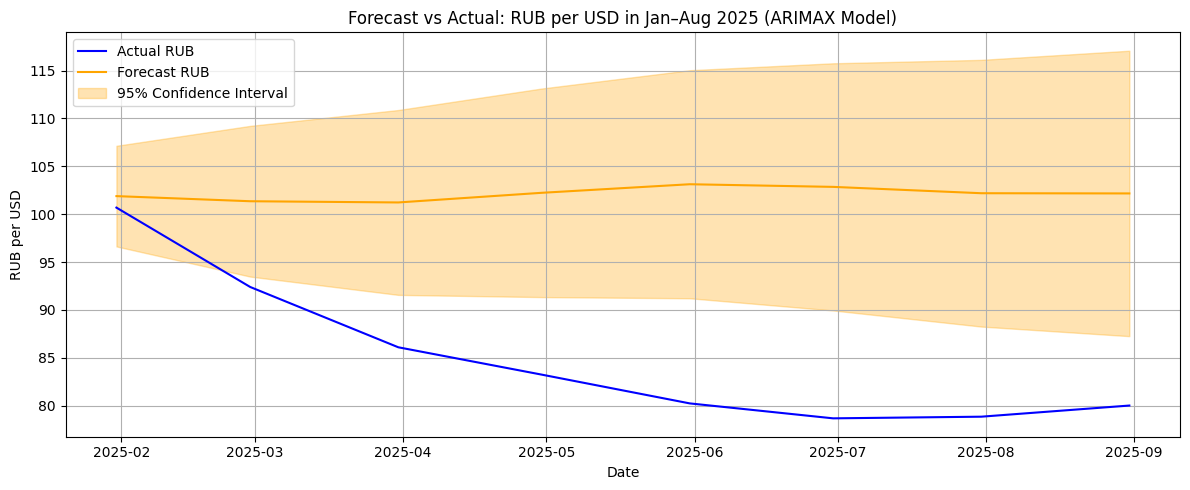

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label='Actual RUB', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast RUB', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='95% Confidence Interval')
plt.title('Forecast vs Actual: RUB per USD in Jan–Aug 2025 (ARIMAX Model)')
plt.xlabel('Date')
plt.ylabel('RUB per USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### IV. Rolling Window

In [80]:
# Define your data and variables
target = 'RUB'
exog_vars = ['Brent_price', 'Brent_price_lag1', 'GDP_per_capita']
data_model = data_lagged.dropna(subset=[target] + exog_vars)

# Rolling window size
window_size = 24  # months (2 years)

# Forecast results
preds = []
actuals = []

# Index where to start forecasting (e.g., after 2 years)
start_idx = window_size

In [81]:
for i in range(start_idx, len(data_model)-1):
    train_slice = data_model.iloc[i - window_size:i]
    test_slice = data_model.iloc[i + 1:i + 2]  # 1-step ahead
    
    y_train = train_slice[target]
    X_train = train_slice[exog_vars]
    
    y_test = test_slice[target].values[0]
    X_test = test_slice[exog_vars]
    
    model = SARIMAX(
        y_train,
        exog=X_train,
        order=(2, 1, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    
    forecast = result.get_forecast(steps=1, exog=X_test)
    forecast_value = forecast.predicted_mean.iloc[0]
    
    preds.append(forecast_value)
    actuals.append(y_test)

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anacon

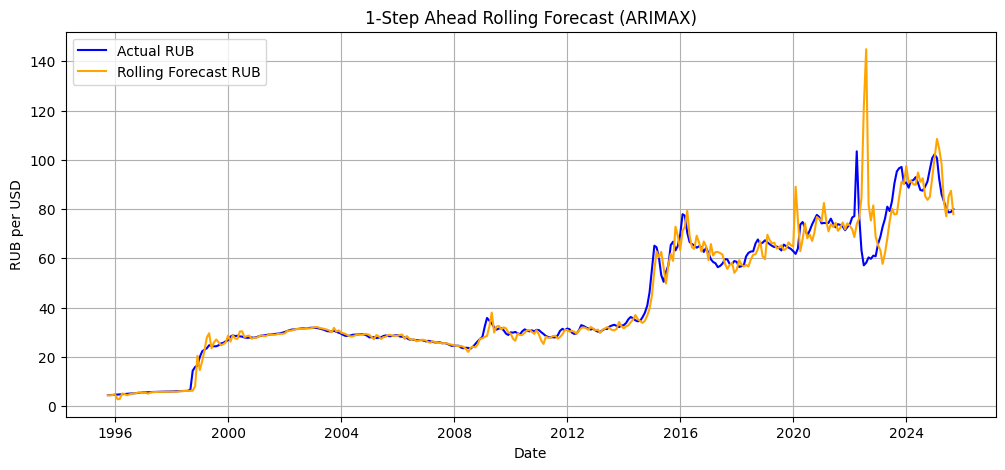

In [82]:
# Align indices
forecast_index = data_model.iloc[start_idx+1:].index[:len(preds)]

plt.figure(figsize=(12, 5))
plt.plot(forecast_index, actuals, label='Actual RUB', color='blue')
plt.plot(forecast_index, preds, label='Rolling Forecast RUB', color='orange')
plt.title("1-Step Ahead Rolling Forecast (ARIMAX)")
plt.xlabel("Date")
plt.ylabel("RUB per USD")
plt.legend()
plt.grid(True)
plt.show()

In [294]:
data_work = data.copy()

In [370]:
# Define CV blocks
cv_blocks = [
    (1992, 1999, 2000),
    (2000, 2007, 2008),
    (2008, 2015, 2016),
    (2016, 2023, 2024),
]

# Create train/test masks for each fold
for fold, (train_start, train_end, test_year) in enumerate(cv_blocks, start=1):
    data_work[f"train{fold}"] = (data_work["year"] >= train_start) & (data_work["year"] <= train_end)
    data_work[f"test{fold}"]  = data_work["year"] == test_year

data_work["holdout"] = data_work["year"] == 2025

In [296]:
data_work

,date,currency_rate,year,quarter,month,day,dow,weekend,currency_rate_change,denomination,...,Inflation,train1,test1,train2,test2,train3,test3,train4,test4,holdout
0,1992-07-31,141.556000,1992.0,3.0,7.0,16.000000,4.000000,0.0,2.928888,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
1,1992-08-31,168.162500,1992.0,3.0,8.0,16.500000,4.000000,0.0,3.274988,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
2,1992-09-30,220.488889,1992.0,3.0,9.0,15.333333,3.888889,0.0,2.546404,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
3,1992-10-31,353.777778,1992.0,4.0,10.0,16.666667,4.111111,0.0,5.348118,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
4,1992-11-30,426.250000,1992.0,4.0,11.0,15.500000,4.000000,0.0,1.491099,pre,...,1490.418425,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2025-04-30,83.243645,2025.0,2.0,4.0,15.318182,2.954545,0.0,-0.213785,post,...,8.140000,False,False,False,False,False,False,False,False,True
394,2025-05-31,80.237650,2025.0,2.0,5.0,17.150000,3.000000,0.0,-0.178412,post,...,8.140000,False,False,False,False,False,False,False,False,True
395,2025-06-30,78.677635,2025.0,2.0,6.0,15.400000,2.850000,0.0,-0.004909,post,...,8.140000,False,False,False,False,False,False,False,False,True
396,2025-07-31,78.850139,2025.0,3.0,7.0,16.000000,3.000000,0.0,0.101659,post,...,8.140000,False,False,False,False,False,False,False,False,True


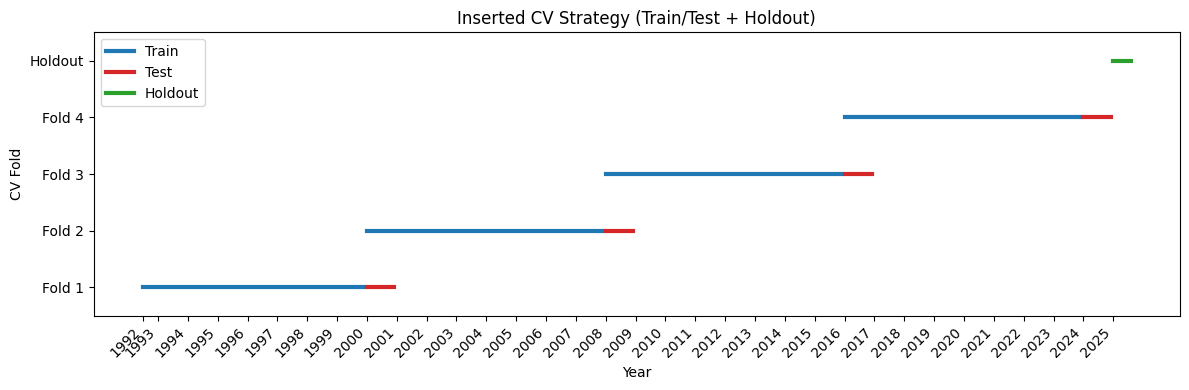

In [284]:
fig, ax = plt.subplots(figsize=(12, 4))

# Plot CV folds
for fold in range(1, 5):
    train_mask = data_work[f"train{fold}"]
    test_mask  = data_work[f"test{fold}"]

    # Train
    ax.plot(
        data_work.loc[train_mask, "date"], 
        [fold] * train_mask.sum(), 
        color='tab:blue', 
        label="Train" if fold == 1 else "", 
        linewidth=3  
    )

    # Test
    ax.plot(
        data_work.loc[test_mask, "date"], 
        [fold] * test_mask.sum(), 
        color='tab:red', 
        label="Test" if fold == 1 else "", 
        linewidth=3  
    )

# --- Holdout (year 2025) ---
holdout_mask = data_work["holdout"]
ax.plot(
    data_work.loc[holdout_mask, "date"], 
    [5] * holdout_mask.sum(), 
    color='tab:green', 
    label="Holdout", 
    linewidth=3
)

# --- Y axis labels ---
yticks = list(range(1, 6))
yticklabels = [f"Fold {i}" for i in range(1, 5)] + ["Holdout"]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylim(0.5, 5.5)
ax.set_ylabel("CV Fold")

# --- X axis: yearly ticks ---
years = pd.to_datetime(data_work["date"]).dt.year.unique()
years = sorted(years)
year_to_first_date = {
    year: data_work.loc[pd.to_datetime(data_work["date"]).dt.year == year, "date"].iloc[0]
    for year in years
}
x_tick_positions = [year_to_first_date[year] for year in years]
ax.set_xticks(x_tick_positions)
ax.set_xticklabels([str(year) for year in years], rotation=45, ha='right')

# Final formatting
ax.set_xlabel("Year")
ax.set_title("Inserted CV Strategy (Train/Test + Holdout)")
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

#### 2.1 Auto Arima with no Intercept

In [ ]:
#Auto_arima with no intercept (trend='n')

model_1 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    trend='n'            
)


best_order = model_1.order  #
print("Best ARIMA order:", best_order)

mse_2 = []

for i in range(1, 5):
    
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    model_cv = ARIMA(endog=y_train, order=best_order, trend='n').fit()  # Avoid overwriting model_1
    phat = model_cv.forecast(steps=len(y_test))
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.03 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [261]:
print(model_1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  398
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -953.918
Date:                Wed, 17 Sep 2025   AIC                           1917.836
Time:                        17:45:40   BIC                           1937.756
Sample:                             0   HQIC                          1925.727
                                - 398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8660      0.028     31.111      0.000       0.811       0.921
ar.L2         -0.9587      0.019    -51.663      0.000      -0.995      -0.922
ma.L1         -0.7949      0.036    -22.143      0.0

#### 2.2 Auto Arima with Intercept (t)

In [264]:
# Auto_arima with intercept (trend='t')

model_2 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              
    seasonal=False,      
    stepwise=True,       
    trace=True,          
    trend='t'            
)

best_order = model_2.order
print("Best ARIMA order:", best_order)

mse_2 = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test"  + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Use trend='t' to match the auto_arima model
    model_cv = ARIMA(endog=y_train, order=best_order, trend='t').fit()
    phat = model_cv.forecast(steps=len(y_test))
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.619, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1927.283, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.775, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.619, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1929.128, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.734, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1929.512, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1926.775, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.404 seconds
Best ARIMA order: (0, 1, 1)
CV RMSE (Auto ARIMA): 6.1064849218541495
     lb_stat  lb_pvalue
10  1.533744   0.998826


In [266]:
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  398
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -960.387
Date:                Wed, 17 Sep 2025   AIC                           1926.775
Time:                        17:48:10   BIC                           1938.727
Sample:                             0   HQIC                          1931.509
                                - 398                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0008      0.001      1.480      0.139      -0.000       0.002
ma.L1          0.1569      0.013     12.021      0.000       0.131       0.182
sigma2         7.3911      0.132     56.023      0.0

#### 2.3 ARIMAX without Intercept (Shocks + Oil Price & Inflation)

In [297]:
# Make sure date column is datetime and set as index
data_work["date"] = pd.to_datetime(data_work["date"])
data_work = data_work.set_index("date").asfreq("M")

# Define shocks by year-month ranges
shock_windows = {
    "shock_1998_default": ((1998, 8), (1998, 11)),
    "shock_2008_gfc": ((2008, 9), (2008, 12)),
    "shock_2014_crimea": ((2014, 3), (2014, 6)),
    "shock_2020_covid": ((2020, 3), (2020, 6)),
    "shock_2022_invasion": ((2022, 2), (2022, 5)),
}

# Add dummy variables for shocks
for shock_name, ((start_y, start_m), (end_y, end_m)) in shock_windows.items():
    mask = (
        ((data_work.index.year > start_y) | ((data_work.index.year == start_y) & (data_work.index.month >= start_m)))
        & ((data_work.index.year < end_y) | ((data_work.index.year == end_y) & (data_work.index.month <= end_m)))
    )
    data_work[shock_name] = mask.astype(int)

# Quick check
print(data_work[[c for c in data_work.columns if "shock" in c]].sum())

shock_1998_default     4
shock_2008_gfc         4
shock_2014_crimea      4
shock_2020_covid       4
shock_2022_invasion    4
dtype: int64


In [312]:
data.columns

Index(['date', 'currency_rate', 'year', 'quarter', 'month', 'day', 'dow',
       'weekend', 'currency_rate_change', 'denomination', 'RUB',
       'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment',
       'Inflation'],
      dtype='object')

In [318]:
exog_all = data_work[[
    "Brent_price", "Inflation",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]


model_3 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'            # no constant
)

best_order = model_3.order
print("Best ARIMAX order:", best_order)

mse_cv = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test" + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()
    phat = model_cv.forecast(steps=len(y_test), exog=exog_test)

    err_sq = (y_test.values - phat.values) ** 2
    mse_cv.append(np.mean(err_sq))

rmse_cv_arimax = float(np.sqrt(np.mean(mse_cv)))
print("Cross-validated RMSE (ARIMAX):", rmse_cv_arimax)

print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

model_3 = ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=best_order,
    trend='n'
).fit()

print(model_3.summary()) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Cross-validated RMSE (ARIMAX): 4.953292300880851
     lb_stat  lb_pvalue
10  0.884669   0.999902
                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -947.265
Date:                Wed, 17 Sep 2025   AIC                           1918.530
Time:                        18:22:57   BIC                           1966.337
Sample:                    07-31-1992   HQIC                          1937.468
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Brent_price            -0.0813      0.022     -3.749      0.000      -0.124      -0.039
Inflati

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 2.4 ARIMAX without Intercept (Shocks + Oil Price, FD Investemnt and GDP)

In [319]:
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]


model_4 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'            # no constant
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

mse_cv = []

for i in range(1, 5):
    train_mask = data_work["train" + str(i)]
    test_mask  = data_work["test" + str(i)]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()
    phat = model_cv.forecast(steps=len(y_test), exog=exog_test)

    err_sq = (y_test.values - phat.values) ** 2
    mse_cv.append(np.mean(err_sq))

rmse_cv_arimax = float(np.sqrt(np.mean(mse_cv)))
print("Cross-validated RMSE (ARIMAX):", rmse_cv_arimax)

print(acorr_ljungbox(model_cv.resid, lags=[10], return_df=True))

model_4 = ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=best_order,
    trend='n'
).fit()

print(model_4.summary()) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.04 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizati

Cross-validated RMSE (ARIMAX): 3.875798415686922
    lb_stat  lb_pvalue
10  1.11913   0.999712
                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                  398
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -950.919
Date:                Wed, 17 Sep 2025   AIC                           1927.838
Time:                        18:23:05   BIC                           1979.629
Sample:                    07-31-1992   HQIC                          1948.354
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Brent_price            -0.0789   4.44e-07  -1.78e+05      0.000      -0.079      -0.079
FD_invest

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### 2.5 ARIMAX without Intercept (Shocks + Oil Price, FD Investemnt and GDP) Plot

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


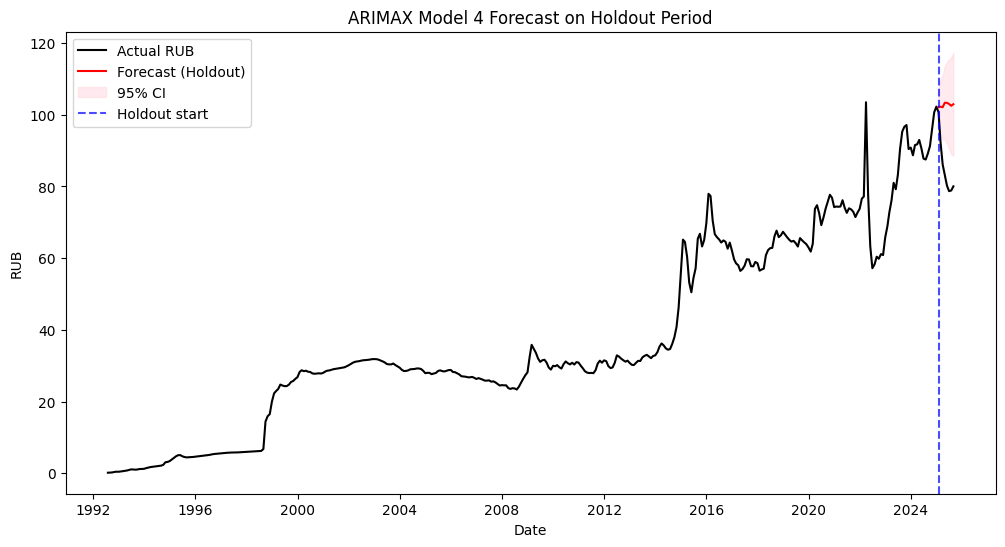

In [ ]:
y = data_work["RUB"]
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work["holdout"]]
exog_train = exog_all[~data_work["holdout"]]

y_holdout = y[data_work["holdout"]]
exog_holdout = exog_all[data_work["holdout"]]

# 2. Refit final ARIMAX on full training data
model_4 = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n").fit()

# 3. Forecast for holdout
forecast_res = model_4.get_forecast(steps=len(y_holdout), exog=exog_holdout)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# 4. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="Forecast (Holdout)", color="red")

# Confidence intervals
plt.fill_between(
    y_holdout.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    color="pink", alpha=0.3, label="95% CI"
)

plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX Model 4 Forecast on Holdout Period")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

### 3. GARCH

In [ ]:
data_work["log_rub"] = np.log(data_work["RUB"])
data_work["ret_rub"] = data_work["log_rub"].diff().dropna()

In [ ]:
!pip install arch 


python(94259) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
11873.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Using cached arch-7.2.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (13 kB)
Using cached arch-7.2.0-cp311-cp311-macosx_11_0_arm64.whl (925 kB)


In [361]:
from arch import arch_model

In [362]:
# Drop NaN after differencing
returns = data_work["ret_rub"].dropna()

# GARCH(1,1) with normal distribution
garch_model = arch_model(returns, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                ret_rub   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                665.663
Distribution:                  Normal   AIC:                          -1323.33
Method:            Maximum Likelihood   BIC:                          -1307.39
                                        No. Observations:                  397
Date:                Wed, Sep 17 2025   Df Residuals:                      396
Time:                        20:48:37   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.0168e-03  3.115e-03     -1.611      0.

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.004705. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Forecasted variances: [0.00130918 0.00187604 0.00235315 0.0027547  0.00309267 0.00337713
 0.00361654 0.00381804 0.00398763 0.00413037 0.0042505  0.00435162]


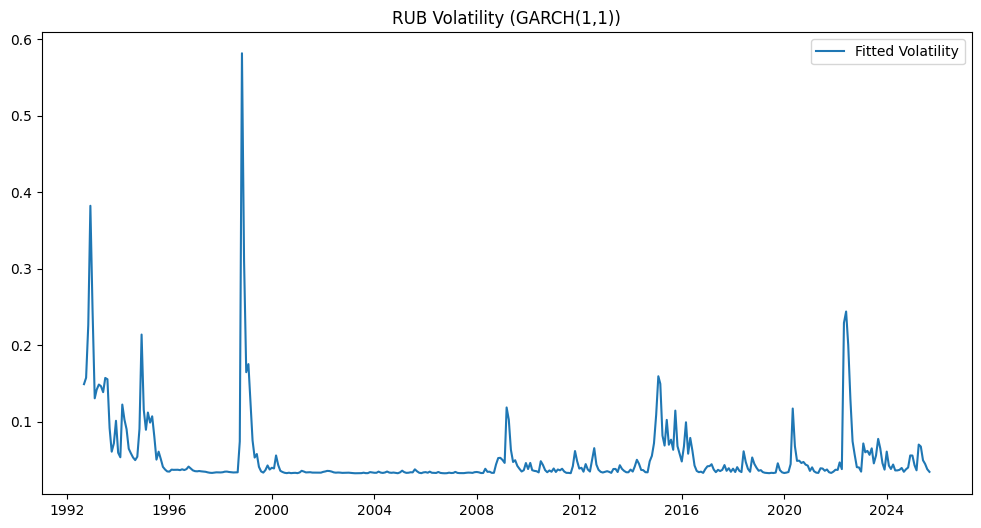

In [363]:
# Forecast next 12 months volatility
garch_forecast = garch_res.forecast(horizon=12)

# Extract conditional variance forecast
vol_forecast = garch_forecast.variance.values[-1, :]
print("Forecasted variances:", vol_forecast)

# Plot conditional volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(garch_res.conditional_volatility, label="Fitted Volatility")
plt.title("RUB Volatility (GARCH(1,1))")
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -621.195
Distribution:                  Normal   AIC:                           1250.39
Method:            Maximum Likelihood   BIC:                           1266.34
                                        No. Observations:                  398
Date:                Wed, Sep 17 2025   Df Residuals:                      397
Time:                        20:50:32   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1066  3.469e-02      3.074  2.113e-03 [3.864e-0

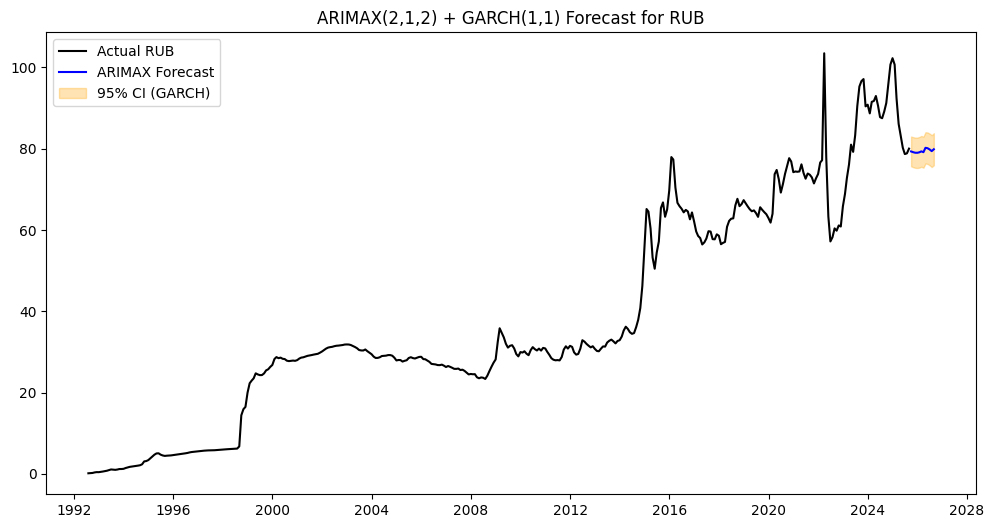

In [364]:
# --- 1. Fit ARIMAX(2,1,2) with exogenous variables ---
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

arimax_model = sm.tsa.ARIMA(
    endog=data_work["RUB"],
    exog=exog_all,
    order=(2,1,2),
    trend='n'
)
arimax_res = arimax_model.fit()

# --- 2. Extract residuals from ARIMAX ---
residuals = arimax_res.resid

# --- 3. Fit GARCH(1,1) on residuals ---
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

print(garch_res.summary())

# --- 4. Forecast volatility ---
garch_forecast = garch_res.forecast(horizon=12)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # standard deviation

# --- 5. Forecast mean RUB (from ARIMAX) ---
steps = 12
exog_future = exog_all.tail(steps)  # replace with your future exog
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_future)
mean_forecast = arimax_forecast.predicted_mean

# --- 6. Combine mean + volatility bands ---
upper = mean_forecast + 1.96 * vol_forecast
lower = mean_forecast - 1.96 * vol_forecast

plt.figure(figsize=(12,6))
plt.plot(data_work.index, data_work["RUB"], label="Actual RUB", color="black")
plt.plot(mean_forecast.index, mean_forecast, label="ARIMAX Forecast", color="blue")
plt.fill_between(mean_forecast.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.legend()
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast for RUB")
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1934.371, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1926.124, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1934.371, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.099, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1928.040, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1925.939, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1917.836, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1923.314, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1923.909, Time=0.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1923.925, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1922.040, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1921.917, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1925.887, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]          

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


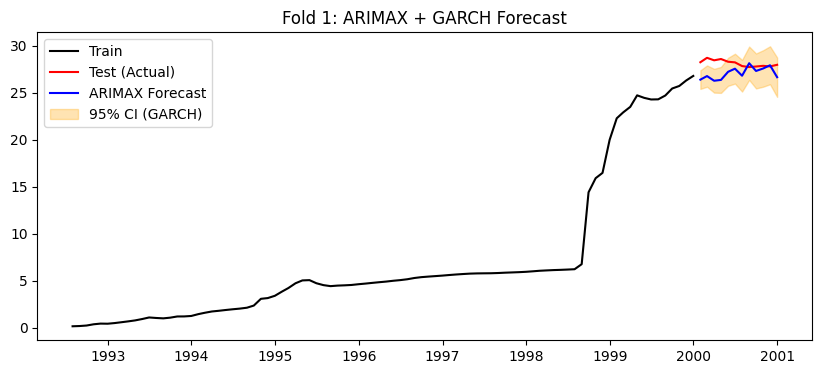

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


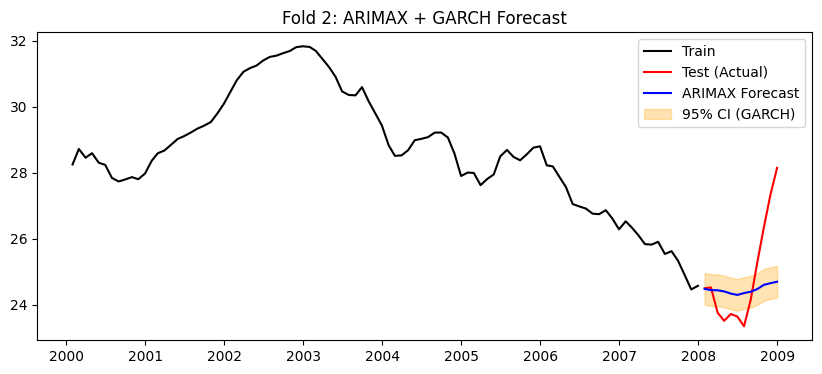

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


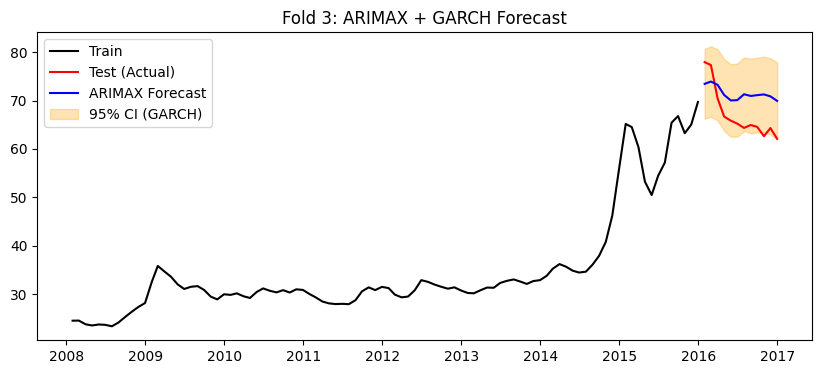

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


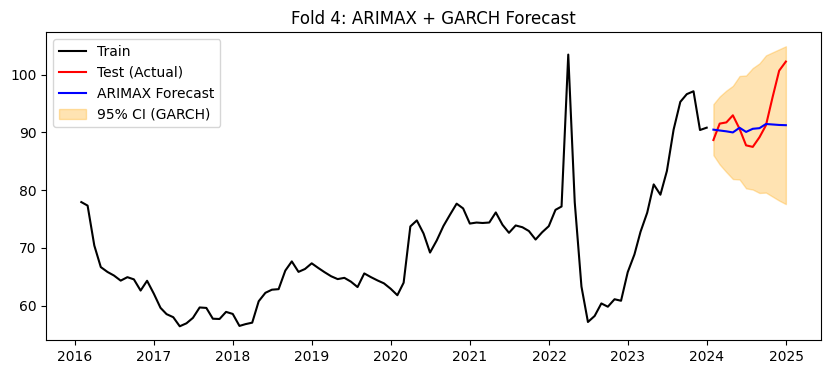

Cross-validated RMSE (ARIMAX+GARCH): 3.338107231557277


In [ ]:

# ======================
# 1. Setup exogenous
# ======================
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

# ======================
# 2. Auto-ARIMAX to get best order
# ======================
model_4 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

# ======================
# 3. Cross-validation with ARIMAX + GARCH
# ======================
rmse_folds = []

for i in range(1, 5):
    # ---- Train/Test split
    train_mask = data_work[f"train{i}"]
    test_mask  = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test  = exog_all.loc[test_mask].sort_index()

    # ---- Step 1: Fit ARIMAX
    model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()

    # ---- Step 2: Get residuals & fit GARCH
    residuals = model_cv.resid
    garch = arch_model(residuals, vol="GARCH", p=1, q=1)
    garch_fit = garch.fit(disp="off")

    # ---- Step 3: Forecast ARIMAX mean
    phat_mean = model_cv.forecast(steps=len(y_test), exog=exog_test)

    # ---- Step 4: Forecast GARCH volatility (optional, CI bands)
    garch_forecast = garch_fit.forecast(horizon=len(y_test))
    vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])

    # ---- Step 5: Evaluate RMSE (using mean only)
    err_sq = (y_test.values - phat_mean.values) ** 2
    rmse = np.sqrt(np.mean(err_sq))
    rmse_folds.append(rmse)

    # ---- Optional Plot per fold
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train, label="Train", color="black")
    plt.plot(y_test.index, y_test, label="Test (Actual)", color="red")
    plt.plot(y_test.index, phat_mean, label="ARIMAX Forecast", color="blue")
    plt.fill_between(y_test.index, phat_mean - 1.96*vol_forecast,
                     phat_mean + 1.96*vol_forecast, color="orange", alpha=0.3,
                     label="95% CI (GARCH)")
    plt.title(f"Fold {i}: ARIMAX + GARCH Forecast")
    plt.legend()
    plt.show()

# ======================
# 4. Final CV RMSE
# ======================
rmse_cv_arimax_garch = float(np.mean(rmse_folds))
print("Cross-validated RMSE (ARIMAX+GARCH):", rmse_cv_arimax_garch)

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


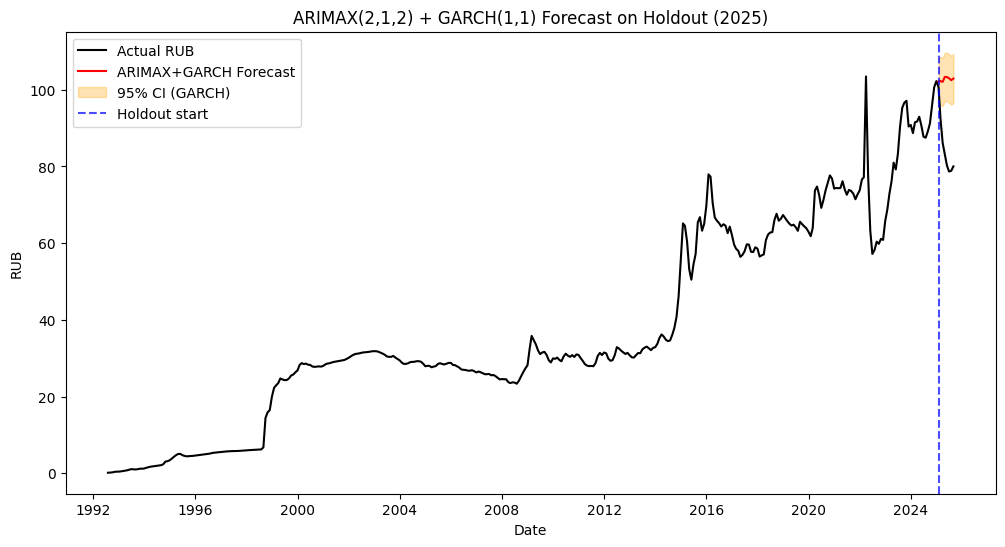

In [366]:
from arch import arch_model

# 1. Endogenous and exogenous split
y = data_work["RUB"]
exog_all = data_work[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work["holdout"]]
exog_train = exog_all[~data_work["holdout"]]

y_holdout = y[data_work["holdout"]]
exog_holdout = exog_all[data_work["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2025)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

### Anotehr Set Up for CV

In [375]:
data_work2 = data[data["year"] <= 2024].copy()

In [376]:
# Define CV blocks

cv_blocks = [
    (1992, 1998, 1999),
    (1999, 2006, 2007),
    (2007, 2014, 2015),
    (2015, 2022, 2023),
]

# Create train/test masks for each fold
for fold, (train_start, train_end, test_year) in enumerate(cv_blocks, start=1):
    data_work2[f"train{fold}"] = (data_work2["year"] >= train_start) & (data_work2["year"] <= train_end)
    data_work2[f"test{fold}"]  = data_work2["year"] == test_year

data_work2["holdout"] = data_work2["year"] == 2024

In [379]:
data_work2.columns

Index(['date', 'currency_rate', 'year', 'quarter', 'month', 'day', 'dow',
       'weekend', 'currency_rate_change', 'denomination', 'RUB',
       'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment',
       'Inflation', 'train1', 'test1', 'train2', 'test2', 'train3', 'test3',
       'train4', 'test4', 'holdout'],
      dtype='object')

In [382]:
# Make sure date column is datetime and set as index
data_work2["date"] = pd.to_datetime(data_work2["date"])
data_work2 = data_work2.set_index("date").asfreq("M")

# Define shocks by year-month ranges
shock_windows = {
    "shock_1998_default": ((1998, 8), (1998, 11)),
    "shock_2008_gfc": ((2008, 9), (2008, 12)),
    "shock_2014_crimea": ((2014, 3), (2014, 6)),
    "shock_2020_covid": ((2020, 3), (2020, 6)),
    "shock_2022_invasion": ((2022, 2), (2022, 5)),
}

# Add dummy variables for shocks
for shock_name, ((start_y, start_m), (end_y, end_m)) in shock_windows.items():
    mask = (
        ((data_work2.index.year > start_y) | ((data_work2.index.year == start_y) & (data_work2.index.month >= start_m)))
        & ((data_work2.index.year < end_y) | ((data_work2.index.year == end_y) & (data_work2.index.month <= end_m)))
    )
    data_work2[shock_name] = mask.astype(int)

# Quick check
print(data_work2[[c for c in data_work2.columns if "shock" in c]].sum())

shock_1998_default     4
shock_2008_gfc         4
shock_2014_crimea      4
shock_2020_covid       4
shock_2022_invasion    4
dtype: int64


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1885.995, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1881.285, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1880.788, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1885.995, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1882.784, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1882.772, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1881.000, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1880.788, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.933 seconds
Best ARIMAX order: (0, 1, 1)


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


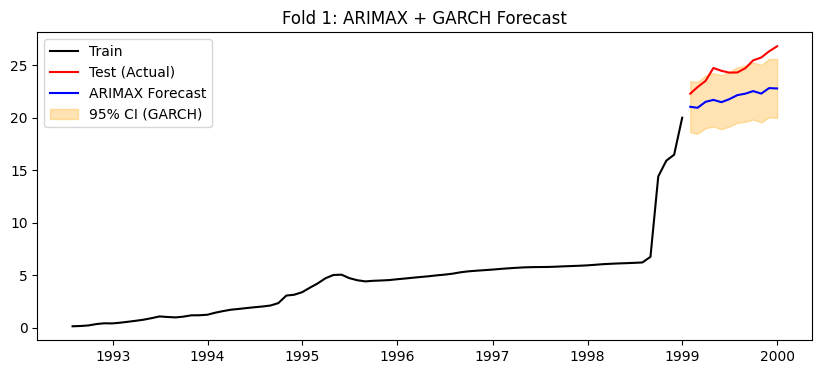

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


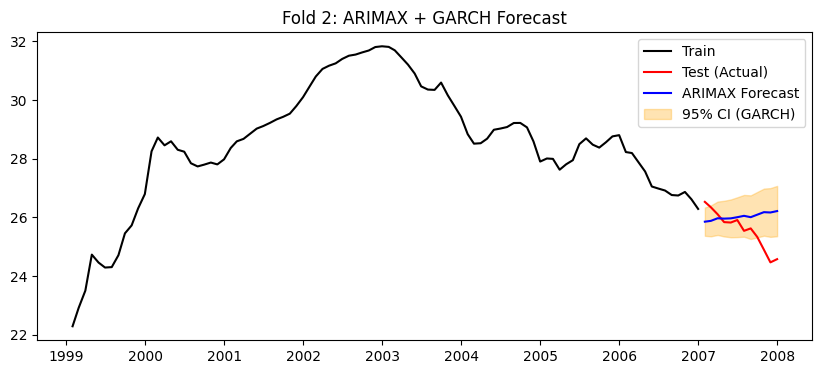

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


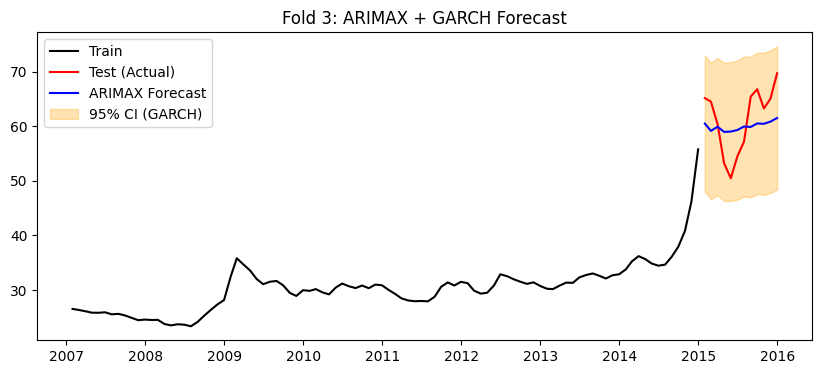

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


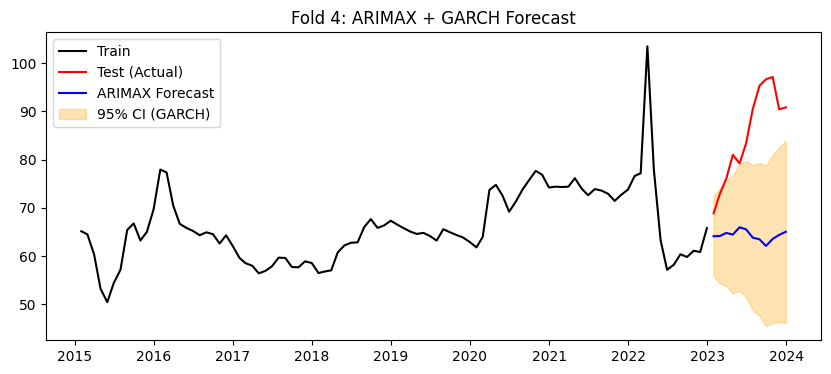

Cross-validated RMSE (ARIMAX+GARCH): 8.022831899903174


In [384]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. Setup exogenous
# ======================
# Only use exogenous variables that exist in data_work2
exog_cols = [
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]
exog_all = data_work2[[col for col in exog_cols if col in data_work2.columns]]

# ======================
# 2. Auto-ARIMAX to get best order
# ======================
model_4 = auto_arima(
    y=data_work2["RUB"], 
    exogenous=exog_all if not exog_all.empty else None,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'
)

best_order = model_4.order
print("Best ARIMAX order:", best_order)

# ======================
# 3. Cross-validation with ARIMAX + GARCH
# ======================
rmse_folds = []

for i in range(1, 5):
    # ---- Train/Test split
    train_mask = data_work2[f"train{i}"]
    test_mask  = data_work2[f"test{i}"]

    y_train = data_work2.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work2.loc[test_mask, "RUB"].sort_index()

    exog_train = exog_all.loc[train_mask].sort_index() if not exog_all.empty else None
    exog_test  = exog_all.loc[test_mask].sort_index() if not exog_all.empty else None

    # ---- Step 1: Fit ARIMAX
    try:
        model_cv = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='n').fit()
    except Exception as e:
        print(f"ARIMAX fit failed for fold {i}: {e}")
        rmse_folds.append(np.nan)
        continue

    # ---- Step 2: Get residuals & fit GARCH
    residuals = model_cv.resid
    try:
        garch = arch_model(residuals, vol="GARCH", p=1, q=1)
        garch_fit = garch.fit(disp="off")
    except Exception as e:
        print(f"GARCH fit failed for fold {i}: {e}")
        rmse_folds.append(np.nan)
        continue

    # ---- Step 3: Forecast ARIMAX mean
    try:
        phat_mean = model_cv.forecast(steps=len(y_test), exog=exog_test)
    except Exception as e:
        print(f"ARIMAX forecast failed for fold {i}: {e}")
        rmse_folds.append(np.nan)
        continue

    # ---- Step 4: Forecast GARCH volatility (optional, CI bands)
    try:
        garch_forecast = garch_fit.forecast(horizon=len(y_test))
        vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])
    except Exception as e:
        print(f"GARCH forecast failed for fold {i}: {e}")
        vol_forecast = np.zeros(len(y_test))

    # ---- Step 5: Evaluate RMSE (using mean only)
    err_sq = (y_test.values - phat_mean.values) ** 2
    rmse = np.sqrt(np.mean(err_sq))
    rmse_folds.append(rmse)

    # ---- Optional Plot per fold
    plt.figure(figsize=(10,4))
    plt.plot(y_train.index, y_train, label="Train", color="black")
    plt.plot(y_test.index, y_test, label="Test (Actual)", color="red")
    plt.plot(y_test.index, phat_mean, label="ARIMAX Forecast", color="blue")
    plt.fill_between(y_test.index, phat_mean - 1.96*vol_forecast,
                     phat_mean + 1.96*vol_forecast, color="orange", alpha=0.3,
                     label="95% CI (GARCH)")
    plt.title(f"Fold {i}: ARIMAX + GARCH Forecast")
    plt.legend()
    plt.show()

# ======================
# 4. Final CV RMSE
# ======================
rmse_cv_arimax_garch = float(np.nanmean(rmse_folds))
print("Cross-validated RMSE (ARIMAX+GARCH):", rmse_cv_arimax_garch)

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


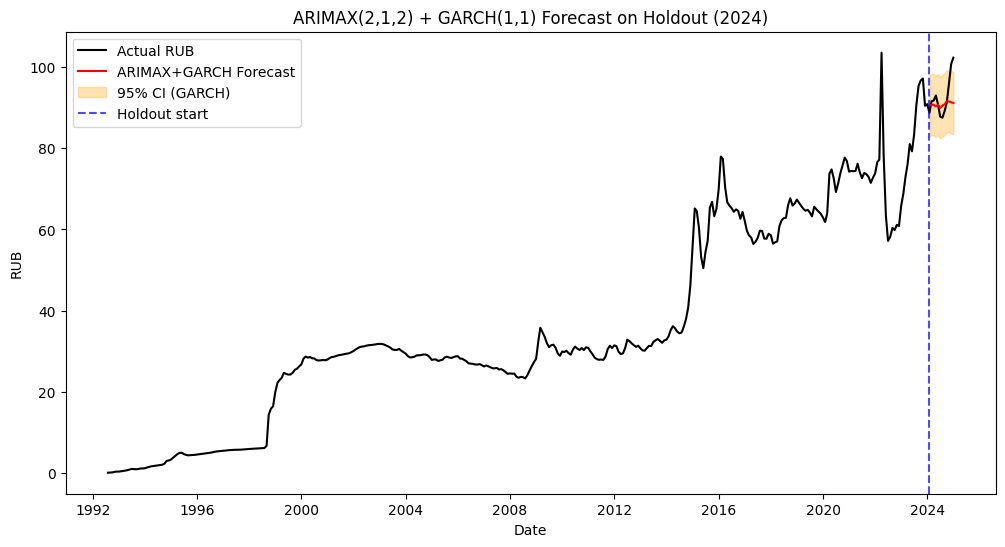

In [ ]:
# 1. Endogenous and exogenous split
y = data_work2["RUB"]
exog_all = data_work2[[
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

y_train = y[~data_work2["holdout"]]
exog_train = exog_all2[~data_work2["holdout"]]

y_holdout = y[data_work2["holdout"]]
exog_holdout = exog_all[data_work2["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2025)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


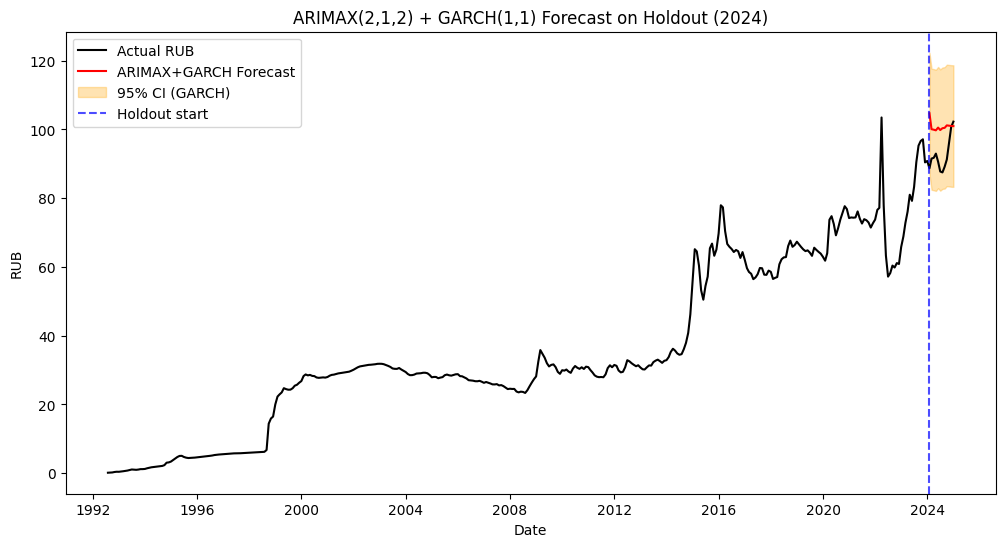

In [ ]:
from arch import arch_model

# 1. Endogenous and exogenous split
y = data_work2["RUB"]

# Only use exogenous variables that exist in the dataframe
exog_cols = [col for col in [
    "Brent_price", "FD_investment",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
] if col in data_work2.columns]
exog_all = data_work2[exog_cols]

y_train = y[~data_work2["holdout"]]
exog_train = exog_all[~data_work2["holdout"]]

y_holdout = y[data_work2["holdout"]]
exog_holdout = exog_all[data_work2["holdout"]]

# 2. Fit ARIMAX on training set
arimax_model = ARIMA(endog=y_train, exog=exog_train, order=(2,1,2), trend="n")
arimax_res = arimax_model.fit()

# 3. Take residuals from ARIMAX → fit GARCH(1,1)
residuals = arimax_res.resid
garch_model = arch_model(residuals, vol="GARCH", p=1, q=1, dist="normal")
garch_res = garch_model.fit(disp="off")

# 4. Forecast ARIMAX mean for holdout
steps = len(y_holdout)
arimax_forecast = arimax_res.get_forecast(steps=steps, exog=exog_holdout)
forecast_mean = arimax_forecast.predicted_mean

# 5. Forecast volatility from GARCH for the same horizon
garch_forecast = garch_res.forecast(horizon=steps)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev

# 6. Build GARCH-based CI
upper = forecast_mean + 1.96 * vol_forecast
lower = forecast_mean - 1.96 * vol_forecast

# 7. Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, forecast_mean, label="ARIMAX+GARCH Forecast", color="red")
plt.fill_between(y_holdout.index, lower, upper, color="orange", alpha=0.3, label="95% CI (GARCH)")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.title("ARIMAX(2,1,2) + GARCH(1,1) Forecast on Holdout (2024)")
plt.xlabel("Date")
plt.ylabel("RUB")
plt.legend()
plt.show()

In [ ]:

import pandas as pd
import numpy as np
# --- Create lag features for RUB ---
max_lag = 12  # use up to 12 months of lags
for lag in range(1, max_lag+1):
    data_work2[f"RUB_lag{lag}"] = data_work2["RUB"].shift(lag)

# --- Optionally add rolling features ---
data_work2["RUB_roll3"] = data_work2["RUB"].rolling(window=3).mean()
data_work2["RUB_roll6"] = data_work2["RUB"].rolling(window=6).mean()

# --- Define target and features ---
y = data_work2["RUB"]
exog_cols = [col for col in [
    "Brent_price", "FD_investment",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
] if col in data_work2.columns]

X = data_work2[[f"RUB_lag{i}" for i in range(1, max_lag+1)] + exog_cols + ["RUB_roll3", "RUB_roll6"]]

In [392]:
X_train = X[~data_work2["holdout"]].dropna()
y_train = y.loc[X_train.index]

X_holdout = X[data_work2["holdout"]].dropna()
y_holdout = y.loc[X_holdout.index]

In [396]:
!pip install xgboost

python(45645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
500025.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.6 MB/s  0:00:00


In [408]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_holdout, label=y_holdout)

# 2. Params
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# 3. Train with early stopping
watchlist = [(dtrain, "train"), (dvalid, "valid")]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False
)

# 4. Predict on holdout
y_pred = xgb_model.predict(dvalid)

# 5. RMSE
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred))
print(f"Holdout RMSE: {rmse:.3f}")

Holdout RMSE: 5.013


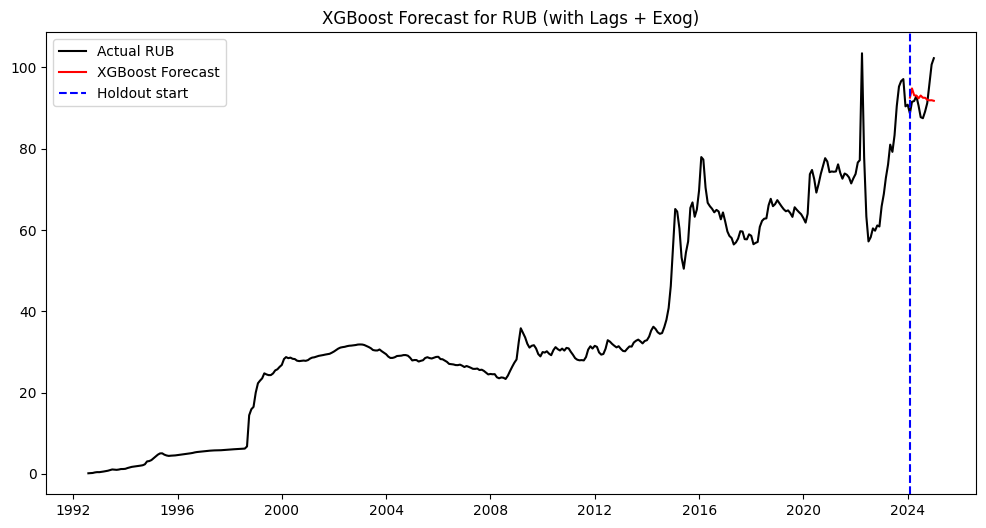

In [409]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, y_pred, label="XGBoost Forecast", color="red")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", label="Holdout start")
plt.title("XGBoost Forecast for RUB (with Lags + Exog)")
plt.legend()
plt.show()

CV RMSE (per fold): [1.476464370192401, 1.0044087307042429, 5.740794321572475, 5.9258655730818335]
Average CV RMSE: 3.5368832488877375


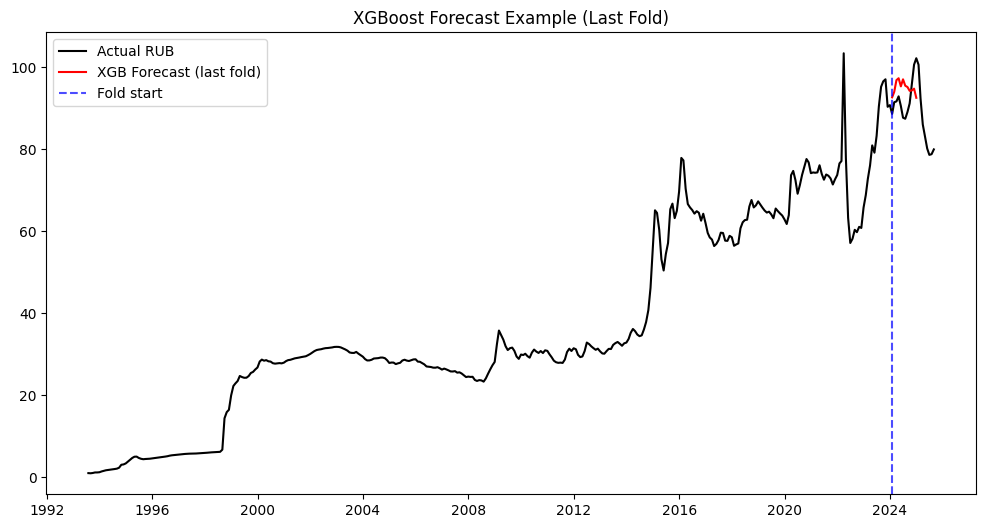

Holdout RMSE: 6.242


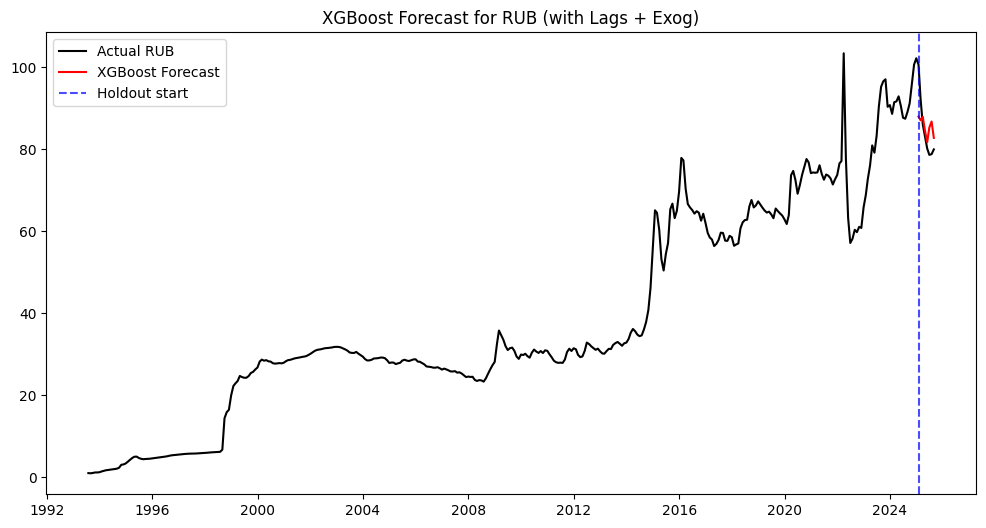

In [410]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# -------------------------------
# 1. Feature engineering
# -------------------------------
df = data_work.copy()

# Lags
for lag in [1, 2, 3, 6, 12]:
    df[f"RUB_lag{lag}"] = df["RUB"].shift(lag)

# Rolling mean/std
df["RUB_roll_mean3"] = df["RUB"].shift(1).rolling(3).mean()
df["RUB_roll_std3"]  = df["RUB"].shift(1).rolling(3).std()

# Time features
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["year"] = df.index.year

# Exogenous variables (already in your dataset)
exog_cols = [
    "Brent_price", "FD_investment", "GDP_per_capita",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]

feature_cols = [c for c in df.columns if "RUB_lag" in c or "RUB_roll" in c] + exog_cols + ["month","quarter","year"]

# Drop NA from lagging
df = df.dropna()

# -------------------------------
# 2. Walk-forward CV
# -------------------------------
rmse_folds = []
fold_forecasts = []

for i in range(1, 5):
    train_mask = df[f"train{i}"]
    test_mask  = df[f"test{i}"]

    X_train, y_train = df.loc[train_mask, feature_cols], df.loc[train_mask, "RUB"]
    X_test,  y_test  = df.loc[test_mask, feature_cols], df.loc[test_mask, "RUB"]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.05,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=[(dtrain, "train"), (dtest, "valid")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Forecast
    y_pred = xgb_model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_folds.append(rmse)

    fold_forecasts.append((y_test.index, y_test, y_pred))

print("CV RMSE (per fold):", rmse_folds)
print("Average CV RMSE:", np.mean(rmse_folds))

# -------------------------------
# 3. Plot one fold example
# -------------------------------
plt.figure(figsize=(12,6))
idx, actual, pred = fold_forecasts[-1]  # last fold
plt.plot(df.index, df["RUB"], color="black", label="Actual RUB")
plt.plot(idx, pred, color="red", label="XGB Forecast (last fold)")
plt.axvline(idx[0], color="blue", linestyle="--", alpha=0.7, label="Fold start")
plt.legend()
plt.title("XGBoost Forecast Example (Last Fold)")
plt.show()

# -------------------------------
# 4. Final model on training + holdout forecast
# -------------------------------
y = df["RUB"]
X = df[feature_cols]

y_train = y[~df["holdout"]]
X_train = X[~df["holdout"]]
y_holdout = y[df["holdout"]]
X_holdout = X[df["holdout"]]

dtrain = xgb.DMatrix(X_train, label=y_train)
dhold  = xgb.DMatrix(X_holdout, label=y_holdout)

final_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=500)
y_pred_holdout = final_model.predict(dhold)

rmse_holdout = np.sqrt(mean_squared_error(y_holdout, y_pred_holdout))
print(f"Holdout RMSE: {rmse_holdout:.3f}")

# Plot holdout forecast
plt.figure(figsize=(12,6))
plt.plot(y.index, y, label="Actual RUB", color="black")
plt.plot(y_holdout.index, y_pred_holdout, label="XGBoost Forecast", color="red")
plt.axvline(y_holdout.index[0], color="blue", linestyle="--", alpha=0.7, label="Holdout start")
plt.legend()
plt.title("XGBoost Forecast for RUB (with Lags + Exog)")
plt.show()